In [2]:
################################################
## setup to use GPU TensorFlow on Colab -- cwr
################################################

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### Slow Ahead!

If you're running without a GPU, this notebook can take a full day and night to run. Training these systems takes time!

## Bonus Chapter 3 - Notebook 3: CNNs

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

import numpy as np

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [4]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
# Make a File_Helper for saving and loading files.

#save_files = True

#import os, sys, inspect
#current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
#sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
#from DLBasics_Utilities import File_Helper
#file_helper = File_Helper(save_files)

In [11]:
random_seed = 42
np.random.seed(random_seed)

In [6]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    #file_helper.save_figure(filename)
    plt.show()

In [7]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [-1, 1]
X_train = np.interp(X_train, [0, 255], [-1,1])
X_test = np.interp(X_test, [0, 255], [-1,1])

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
# Make the different CNN models we use in this chapter

def make_simple_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5),
                     activation='relu', padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_bigger_cnn_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pooling_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3))) 
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     strides=(2, 2), kernel_constraint=MaxNorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_batchnorm_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation=None, padding='same',
                     strides=(2, 2), 
                     input_shape=(image_height, image_width, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_1_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_2_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

In [9]:
def run_model(model_maker, plot_title, filename):
    model = model_maker()
    np.random.seed(random_seed)
    history = model.fit(X_train, y_train, validation_split=0.25, 
                     epochs=100, batch_size=256)
    plot_accuracy_and_loss(history, plot_title, filename)
    return history

Epoch 1/100
176/176 [==============================] - 32s 15ms/step - loss: 0.3560 - accuracy: 0.8952 - val_loss: 0.1338 - val_accuracy: 0.9639
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.1007 - accuracy: 0.9713 - val_loss: 0.0977 - val_accuracy: 0.9717
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0700 - accuracy: 0.9796 - val_loss: 0.0823 - val_accuracy: 0.9752
Epoch 4/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0541 - accuracy: 0.9838 - val_loss: 0.0773 - val_accuracy: 0.9775
Epoch 5/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.0780 - val_accuracy: 0.9769
Epoch 6/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0364 - accuracy: 0.9891 - val_loss: 0.0798 - val_accuracy: 0.9777
Epoch 7/100
176/176 [==============================] - 2s 10ms/step - loss: 0.0291 - accuracy: 0.9913 - val_loss: 0.0775 - val_accuracy

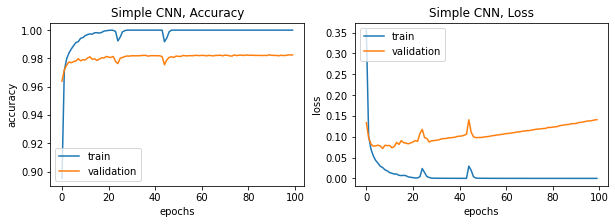

In [10]:
simple_history = run_model(
    make_simple_cnn_model, 'Simple CNN', 'Simple-CNN-graphs')

Epoch 1/100
176/176 [==============================] - 5s 24ms/step - loss: 0.4854 - accuracy: 0.8587 - val_loss: 0.1477 - val_accuracy: 0.9563
Epoch 2/100
176/176 [==============================] - 4s 20ms/step - loss: 0.1235 - accuracy: 0.9639 - val_loss: 0.0862 - val_accuracy: 0.9744
Epoch 3/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0910 - accuracy: 0.9722 - val_loss: 0.0782 - val_accuracy: 0.9771
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0742 - accuracy: 0.9765 - val_loss: 0.0717 - val_accuracy: 0.9783
Epoch 5/100
176/176 [==============================] - 4s 22ms/step - loss: 0.0664 - accuracy: 0.9794 - val_loss: 0.0664 - val_accuracy: 0.9802
Epoch 6/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.0635 - val_accuracy: 0.9815
Epoch 7/100
176/176 [==============================] - 4s 22ms/step - loss: 0.0540 - accuracy: 0.9835 - val_loss: 0.0608 - val_accuracy:

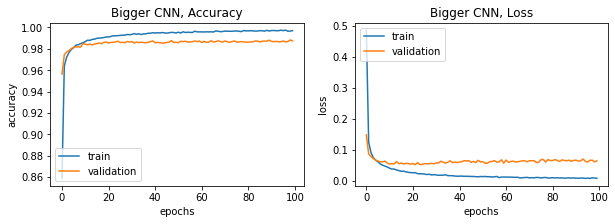

In [11]:
bigger_history = run_model(
    make_bigger_cnn_model, 'Bigger CNN', 'Bigger-CNN-graphs')

Epoch 1/100
176/176 [==============================] - 4s 18ms/step - loss: 0.3854 - accuracy: 0.8862 - val_loss: 0.1312 - val_accuracy: 0.9677
Epoch 2/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0873 - accuracy: 0.9724 - val_loss: 0.0735 - val_accuracy: 0.9799
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.0614 - accuracy: 0.9810 - val_loss: 0.0641 - val_accuracy: 0.9822
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 0.0500 - accuracy: 0.9841 - val_loss: 0.0564 - val_accuracy: 0.9847
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.0414 - accuracy: 0.9873 - val_loss: 0.0468 - val_accuracy: 0.9868
Epoch 6/100
176/176 [==============================] - 3s 16ms/step - loss: 0.0365 - accuracy: 0.9887 - val_loss: 0.0478 - val_accuracy: 0.9857
Epoch 7/100
176/176 [==============================] - 3s 16ms/step - loss: 0.0320 - accuracy: 0.9894 - val_loss: 0.0453 - val_accuracy:

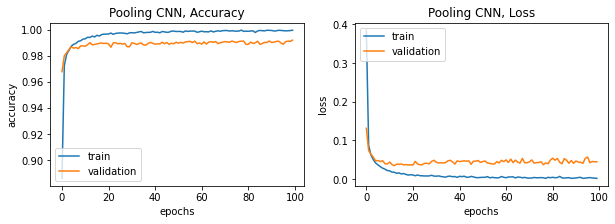

In [12]:
pooling_history = run_model(
    make_pooling_cnn_model, 'Pooling CNN', 'Pooling-CNN-graphs')

Epoch 1/100
176/176 [==============================] - 33s 16ms/step - loss: 0.5457 - accuracy: 0.8256 - val_loss: 0.1373 - val_accuracy: 0.9601
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.1444 - accuracy: 0.9550 - val_loss: 0.0901 - val_accuracy: 0.9729
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.1041 - accuracy: 0.9670 - val_loss: 0.0750 - val_accuracy: 0.9776
Epoch 4/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0840 - accuracy: 0.9739 - val_loss: 0.0693 - val_accuracy: 0.9788
Epoch 5/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0724 - accuracy: 0.9770 - val_loss: 0.0647 - val_accuracy: 0.9807
Epoch 6/100
176/176 [==============================] - 2s 12ms/step - loss: 0.0646 - accuracy: 0.9793 - val_loss: 0.0553 - val_accuracy: 0.9832
Epoch 7/100
176/176 [==============================] - 2s 12ms/step - loss: 0.0579 - accuracy: 0.9819 - val_loss: 0.0577 - val_accuracy

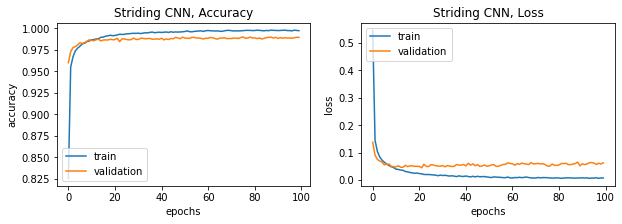

In [12]:
striding_history = run_model(
    make_striding_cnn_model, 'Striding CNN', 'Striding-CNN-graphs')

Epoch 1/100
176/176 [==============================] - 3s 13ms/step - loss: 0.3620 - accuracy: 0.8929 - val_loss: 0.4806 - val_accuracy: 0.8599
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0741 - accuracy: 0.9768 - val_loss: 0.1783 - val_accuracy: 0.9409
Epoch 3/100
176/176 [==============================] - 2s 12ms/step - loss: 0.0494 - accuracy: 0.9845 - val_loss: 0.0863 - val_accuracy: 0.9731
Epoch 4/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0358 - accuracy: 0.9886 - val_loss: 0.0677 - val_accuracy: 0.9805
Epoch 5/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.0583 - val_accuracy: 0.9823
Epoch 6/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0212 - accuracy: 0.9936 - val_loss: 0.0584 - val_accuracy: 0.9827
Epoch 7/100
176/176 [==============================] - 2s 11ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0641 - val_accuracy:

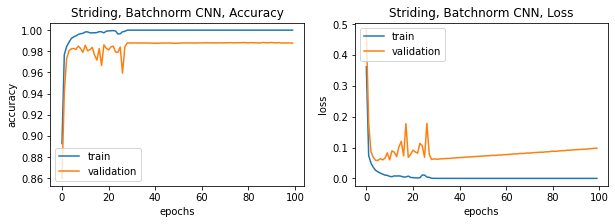

In [13]:
striding_batchnorm_history = run_model(
        make_striding_batchnorm_cnn_model, 
        'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')

Epoch 1/100
176/176 [==============================] - 6s 32ms/step - loss: 0.3070 - accuracy: 0.9040 - val_loss: 0.1149 - val_accuracy: 0.9662
Epoch 2/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0753 - accuracy: 0.9756 - val_loss: 0.0750 - val_accuracy: 0.9781
Epoch 3/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0510 - accuracy: 0.9831 - val_loss: 0.0535 - val_accuracy: 0.9838
Epoch 4/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.0639 - val_accuracy: 0.9805
Epoch 5/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0301 - accuracy: 0.9897 - val_loss: 0.0708 - val_accuracy: 0.9803
Epoch 6/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0240 - accuracy: 0.9918 - val_loss: 0.0739 - val_accuracy: 0.9798
Epoch 7/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0572 - val_accuracy:

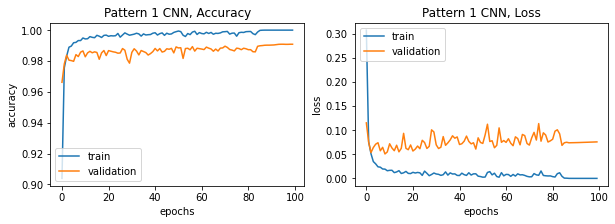

In [15]:
pattern_1_history = run_model(
        make_pattern_1_cnn_model, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')

Epoch 1/100
176/176 [==============================] - 6s 28ms/step - loss: 0.3315 - accuracy: 0.8977 - val_loss: 0.1572 - val_accuracy: 0.9496
Epoch 2/100
176/176 [==============================] - 5s 26ms/step - loss: 0.1136 - accuracy: 0.9653 - val_loss: 0.1105 - val_accuracy: 0.9676
Epoch 3/100
176/176 [==============================] - 5s 26ms/step - loss: 0.0828 - accuracy: 0.9746 - val_loss: 0.0976 - val_accuracy: 0.9699
Epoch 4/100
176/176 [==============================] - 4s 25ms/step - loss: 0.0636 - accuracy: 0.9799 - val_loss: 0.0920 - val_accuracy: 0.9723
Epoch 5/100
176/176 [==============================] - 5s 26ms/step - loss: 0.0503 - accuracy: 0.9839 - val_loss: 0.1109 - val_accuracy: 0.9687
Epoch 6/100
176/176 [==============================] - 4s 25ms/step - loss: 0.0463 - accuracy: 0.9848 - val_loss: 0.0989 - val_accuracy: 0.9729
Epoch 7/100
176/176 [==============================] - 4s 25ms/step - loss: 0.0387 - accuracy: 0.9874 - val_loss: 0.0901 - val_accuracy:

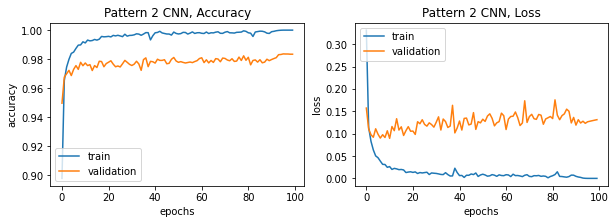

In [16]:
pattern_2_history = run_model(
        make_pattern_2_cnn_model, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')

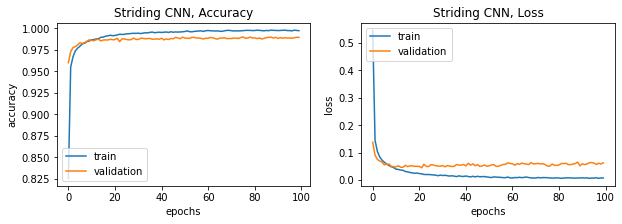

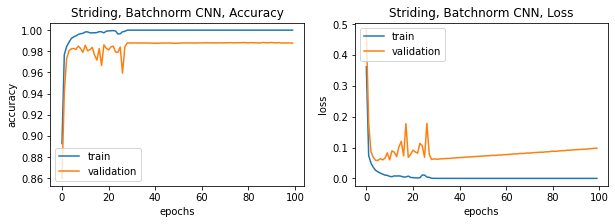

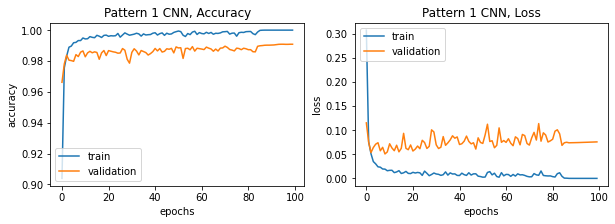

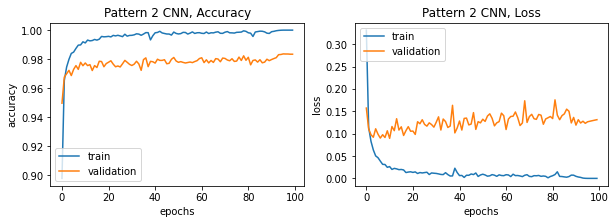

In [18]:
# get the plots by themselves
#plot_accuracy_and_loss(simple_history, 'Simple CNN', 'Simple-CNN-graphs')
#plot_accuracy_and_loss(bigger_history, 'Bigger CNN', 'Bigger-CNN-graphs')
#plot_accuracy_and_loss(pooling_history, 'Pooling CNN', 'Pooling-CNN-graphs')
plot_accuracy_and_loss(striding_history, 'Striding CNN', 'Striding-CNN-graphs')
plot_accuracy_and_loss(striding_batchnorm_history, 'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')
plot_accuracy_and_loss(pattern_1_history, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')
plot_accuracy_and_loss(pattern_2_history, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')